# Decode stimuli/block/licks from neural activity - DR

In [6]:
#Import packages
import pandas as pd
import h5py
import numpy as np
import scipy as sp
import scipy.signal as sg
import xarray as xr
import os
import matplotlib.pyplot as plt
from matplotlib import patches
import ast
from sklearn import svm
import glob
import re
import pickle

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report

from DR_analysis_utils import Session, makePSTH, make_neuron_time_trials_tensor, compute_smoothed_response_rate

%matplotlib notebook

In [3]:
#Set paths to experiment folders
main_path = [
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_626791_20220815\processed",
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_626791_20220816\processed",
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_626791_20220817\processed",
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_636766_20230123\processed", 
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_636766_20230124\processed", 
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_636766_20230125\processed", 
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_636766_20230126\processed", 
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_644864_20230130\processed",
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_644864_20230131\processed", 
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_644864_20230201\processed", 
    r"\\allen\programs\mindscope\workgroups\np-exp\PilotEphys\Task 2 pilot\DRpilot_644864_20230202\processed",
#     r"\\allen\programs\mindscope\workgroups\np-exp\PilotEphys\Task 2 pilot\DRpilot_644866_20230207\processed", 
#     r"Y:\DRpilot_644866_20230208\processed",
#     r"Y:\DRpilot_644866_20230209\processed",
#     r"Y:\DRpilot_644866_20230210\processed",
    r"Y:\DRpilot_644867_20230220\processed",
    r"Y:\DRpilot_644867_20230221\processed",
    r"Y:\DRpilot_644867_20230222\processed",
    r"Y:\DRpilot_644867_20230223\processed",
    r"Y:\DRpilot_649943_20230213\processed", 
    r"Y:\DRpilot_649943_20230214\processed",
    r"Y:\DRpilot_649943_20230215\processed",
    r"Y:\DRpilot_649943_20230216\processed",
]



## Load a single session

In [ ]:
sel_session=0
session=Session(path=main_path[sel_session]) 
session.assign_unit_areas()
session=compute_smoothed_response_rate(session)

In [ ]:
# trials table
session.trials

In [ ]:
# units table
session.good_units

In [ ]:
session.good_units['area'].value_counts()

In [ ]:
# spike times from one unit
session.spike_times[session.units.index[0]]

In [ ]:
# information about each frame
session.frames

In [ ]:
# loop through sessions and make unit xarrays
time_before_flash = 0.5
trial_duration = 1.5
bin_size = 0.001


# Make tensor (3-D matrix [units,time,trials])
trial_tensor = make_neuron_time_trials_tensor(session.good_units, session.spike_times, 
                                              session.trials,time_before_flash, trial_duration, 
                                              bin_size)

# make xarray
session.trial_da = xr.DataArray(trial_tensor, dims=("unit_id", "time", "trials"), 
                           coords={
                               "unit_id": session.good_units.index.values,
                               "time": np.arange(0, trial_duration, bin_size)-time_before_flash,
                               "trials": session.trials.index.values
                               })

### decode by area

In [ ]:
# session.good_units['area'].value_counts()

In [ ]:
#shorten the area names to better lump together units
#get rig of layers and/or sub-areas with dashes
area_short = []
for area in session.good_units['area']:
    if area=='N/A':
        short='N/A'
    elif area[:2]=='CA':
        short=area
    else:
        dig_ind=re.search(r"\d", area)
        dash_ind=re.search(r"-", area)
        if dig_ind!=None:
            short=area[:dig_ind.start()]
        elif dash_ind!=None:
            short=area[:dash_ind.start()]
        else:
            short=area
        
    area_short.append(short)
    
session.good_units['area_short']=area_short

In [ ]:
area_counts=session.good_units['area_short'].value_counts()
area_counts[area_counts>35].index

In [ ]:
session.trials

In [ ]:
# # grab data: make these [trials,neurons] matrices based on different time bins:
# trial_sel=session.trials.query('(trialStimID == "sound1" and trial_response == True)').index

# area_sel = area_counts[area_counts>25].index

# # grab the stimulus ids
# stim_ids = session.trials['trialStimID'][trial_sel].values
# # or, use block IDs
# block_ids = session.trials['trialstimRewarded'][trial_sel].values
# #or, use whether mouse responded
# trial_response = session.trials['trial_response'][trial_sel].values

# # choose what variable to predict
# pred_var = block_ids

# ### make sure equal # of trials per condition!
# conds = np.unique(pred_var)
# cond_count = np.zeros(len(conds))
# for ic,cc in enumerate(conds):
#     cond_count[ic]=np.sum(pred_var==cc)
    
# min_n_trials=np.min(cond_count).astype(int)

# subset_ind=[]

# for cc in conds:
#     cond_inds=np.where(pred_var==cc)[0]
#     subset_ind.append(np.random.choice(cond_inds,min_n_trials,replace=False))
    
# subset_ind=np.sort(np.hstack(subset_ind))

In [ ]:
# subset_ind

In [ ]:
#try more timepoints & split by areas

svc_results={}
binsize=0.1

# grab data: make these [trials,neurons] matrices based on different time bins:

hit_trials = session.trials.query(
    '(trialStimID == "vis1" and \
    trialstimRewarded == "vis1" and \
    trial_response == True and \
    vis_autoreward_trials == False) or \
    (trialStimID == "sound1" and \
    trialstimRewarded == "sound1" and \
    trial_response == True and \
    vis_autoreward_trials == False)').index

cr_trials = session.trials.query(
    '(trialStimID == "vis1" and \
    trialstimRewarded == "sound1" and \
    trial_response == False and \
    vis_autoreward_trials == False) or \
    (trialStimID == "sound1" and \
    trialstimRewarded == "vis1" and \
    trial_response == False and \
    vis_autoreward_trials == False)').index


trial_sel=np.sort(np.hstack([hit_trials,cr_trials]))

area_sel = area_counts[area_counts>30].index
# area_sel = ['all']

# grab the stimulus ids
stim_ids = session.trials['trialStimID'][trial_sel].values
# or, use block IDs
block_ids = session.trials['trialstimRewarded'][trial_sel].values
#or, use whether mouse responded
trial_response = session.trials['trial_response'][trial_sel].values

#choose what variable to predict
pred_var = block_ids

### make sure equal # of trials per condition!
conds = np.unique(pred_var)
cond_count = np.zeros(len(conds))
for ic,cc in enumerate(conds):
    cond_count[ic]=np.sum(pred_var==cc)
min_n_trials=np.min(cond_count).astype(int)
subset_ind=[]
for cc in conds:
    cond_inds=np.where(pred_var==cc)[0]
    subset_ind.append(np.random.choice(cond_inds,min_n_trials,replace=False))   
subset_ind=np.sort(np.hstack(subset_ind))
trial_sel=trial_sel[subset_ind]
pred_var=pred_var[subset_ind]

trnum=40
u_num=30

n_repeats=100

time_bins=np.arange(-0.2,0.6,binsize)

for aa in area_sel:
    if aa=='all':
        unit_sel = session.good_units.index.values
    else:
        unit_sel = session.good_units.query('area_short==@aa').index.values
    svc_results[aa]={}
    
    for tt,t_start in enumerate(time_bins[:-1]):
        svc_results[aa][tt]={}
        
        for nn in range(0,n_repeats):
            unit_subset = np.random.choice(unit_sel,u_num,replace=True)

            ### make sure equal # of trials per condition!
            subset_ind=[]
            conds = np.unique(pred_var)
            cond_count=[]

            for cc in conds:
                cond_inds=np.where(pred_var==cc)[0]
                subset_ind.append(np.random.choice(cond_inds,trnum,replace=False))   
            subset_ind=np.sort(np.hstack(subset_ind))

            sel_data = session.trial_da.sel(time=slice(t_start,time_bins[tt+1]),
                                            trials=trial_sel[subset_ind],
                                            unit_id=unit_subset).mean(dim='time').values

    #         sel_data = session.trial_da.sel(time=slice(t_start,time_bins[tt+1]),
    #                                         trials=trial_sel,unit_id=unit_sel).mean(dim='time').values

            X = sel_data.T
            y = pred_var[subset_ind].flatten()

            xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.5, stratify=y)

            clf = svm.LinearSVC()
            clf.fit(xtrain, ytrain)

            ypred = clf.predict(xtest)

            cr_dict=classification_report(ytest, ypred, output_dict=True)
            cr_df=pd.DataFrame.from_dict(cr_dict)

            svc_results[aa][tt][nn]=cr_df
    
    print(aa+' done')
        

In [ ]:
hit_trials.shape

In [ ]:
# make into more plottable format

plot_results={}

timepoints=time_bins[1:]

areas=area_sel

for aa in areas:
    plot_results[aa]={}
#     plot_results[tt]['modality']=modality
    plot_results[aa]['vis1']=np.zeros((len(timepoints),n_repeats))
    plot_results[aa]['vis1'][:]=np.nan
    plot_results[aa]['vis2']=np.zeros((len(timepoints),n_repeats))
    plot_results[aa]['vis2'][:]=np.nan
    plot_results[aa]['aud1']=np.zeros((len(timepoints),n_repeats))
    plot_results[aa]['aud1'][:]=np.nan
    plot_results[aa]['aud2']=np.zeros((len(timepoints),n_repeats))
    plot_results[aa]['aud2'][:]=np.nan
    
    plot_results[aa]['True']=np.zeros((len(timepoints),n_repeats))
    plot_results[aa]['True'][:]=np.nan
    plot_results[aa]['False']=np.zeros((len(timepoints),n_repeats))
    plot_results[aa]['False'][:]=np.nan
#     for tt,tp in enumerate(timepoints):
#         plot_results[aa][tt]=[]
        

         
# diff table for each timepoint?
# row = session
# columns = ['modality','A_vis','A_aud','B_vis','B_aud','C_vis','C_aud','F_vis','F_aud',]

for aa in areas: #svc_results[ss]['results'].keys():
    if aa in svc_results.keys():
        for tt,tp in enumerate(timepoints):
            
            for nn in range(0,n_repeats):
                if 'vis1' in svc_results[aa][tt][nn].keys():
                    vis1_perf=np.mean(svc_results[aa][tt][nn]['vis1'][['precision','recall']].values)
                    plot_results[aa]['vis1'][tt,nn]=vis1_perf

                if 'vis2' in svc_results[aa][tt][nn].keys():
                    vis2_perf=np.mean(svc_results[aa][tt][nn]['vis2'][['precision','recall']].values)
                    plot_results[aa]['vis2'][tt,nn]=vis2_perf

                if 'sound1' in svc_results[aa][tt][nn].keys():
                    aud1_perf=np.mean(svc_results[aa][tt][nn]['sound1'][['precision','recall']].values)
                    plot_results[aa]['aud1'][tt,nn]=aud1_perf

                if 'sound2' in svc_results[aa][tt][nn].keys():
                    aud2_perf=np.mean(svc_results[aa][tt][nn]['sound2'][['precision','recall']].values)
                    plot_results[aa]['aud2'][tt,nn]=aud2_perf

                if 'True' in svc_results[aa][tt][nn].keys():
                    aud1_perf=np.mean(svc_results[aa][tt][nn]['True'][['precision','recall']].values)
                    plot_results[aa]['True'][tt,nn]=aud1_perf

                if 'False' in svc_results[aa][tt][nn].keys():
                    aud2_perf=np.mean(svc_results[aa][tt][nn]['False'][['precision','recall']].values)
                    plot_results[aa]['False'][tt,nn]=aud2_perf

#     plot_results[tt]=pd.DataFrame.from_dict(plot_results[tt])

In [ ]:
svc_results[aa][tt][nn]['vis1']

In [ ]:
# plot_results
np.std(np.hstack([plot_results[area]['vis1'],plot_results[area]['aud1']]),1)
# np.hstack([plot_results[area]['vis1'],plot_results[area]['aud1']]).shape

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(6,4))



for aa,area in enumerate(plot_results.keys()):
    y=np.nanmean([np.mean(plot_results[area]['vis1'],1),np.mean(plot_results[area]['aud1'],1)],0)
    yerr=np.std(np.hstack([plot_results[area]['vis1'],plot_results[area]['aud1']]),1)/np.sqrt(n_repeats)
#     ax.plot(timepoints,np.mean([plot_results[area]['vis1'],plot_results[area]['aud1']],0))
    linex=ax.plot(timepoints,y)
    plt.fill_between(timepoints, y-yerr, y+yerr,
                    alpha=0.2, edgecolor=None, facecolor=linex[0].get_color())
    
#     ax[aa].plot(timepoints,plot_results[area]['aud1'])

ax.set_ylim([0.4,1.0])
ax.axvline(0,color='k')
# ax.axhline(0.25,color='k',linewidth=0.5,linestyle='--')
ax.axhline(0.5,color='k',linewidth=0.5,linestyle='--')
ax.set_title(session.metadata['mouseID']+' session '+str(session.metadata['ephys_session_num'])+
            '; n_units='+str(u_num)+'; n_trials='+str(trnum)+'; n_repeats='+str(n_repeats))
# ax.set_title(area)
# ax.set_xticklabels('')
ax.legend(plot_results.keys(),ncol=3)
ax.set_ylabel('decodability of context')
ax.set_xlabel('time from stimulus onset (s)')
fig.tight_layout()

In [ ]:
# fig,ax=plt.subplots(len(plot_results.keys()),1,figsize=(6,20))

# if type(ax)!=np.ndarray:
#     ax=[ax]

# for aa,area in enumerate(plot_results.keys()):
#     ax[aa].plot(timepoints,np.mean([plot_results[area]['vis1'],plot_results[area]['aud1']],0))
# #     ax[aa].plot(timepoints,plot_results[area]['aud1'])
#     ax[aa].set_ylim([-0.1,1.1])
#     ax[aa].axvline(0,color='k')
#     ax[aa].axhline(0.25,color='k',linewidth=0.5,linestyle='--')
#     ax[aa].axhline(0.5,color='k',linewidth=0.5,linestyle='--')
#     ax[aa].set_title(area)
#     if aa<len(plot_results.keys())-1:
#         ax[aa].set_xticklabels('')

# ax[aa].set_xlabel('time from stimulus onset (s)')
# fig.tight_layout()

## loop through experiments & plot

probeA areas found
probeB areas found
probeC areas found
probeD areas not found
probeE areas found
probeF areas found


C:\Users\ethan.mcbride\Code\dynamic_routing_ephys\analysis\DR_analysis_utils.py:1069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stimTrials[ss+'_smooth']=sg.convolve(stimTrials['trial_response'].values,gwindow,mode='same')/np.sum(gwindow)
C:\Users\ethan.mcbride\Code\dynamic_routing_ephys\analysis\DR_analysis_utils.py:1069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stimTrials[ss+'_smooth']=sg.convolve(stimTrials['trial_response'].values,gwindow,mode='same')/np.sum(gwindow)
C:\Users\ethan.mcbride\Code\

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

ProS done


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

CP done


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

MOs done


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

LP done


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

VISl done


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

RSPagl done


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

SGN done


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

APN done


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

PoT done


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

VISp done


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

CA1 done


<IPython.core.display.Javascript object>


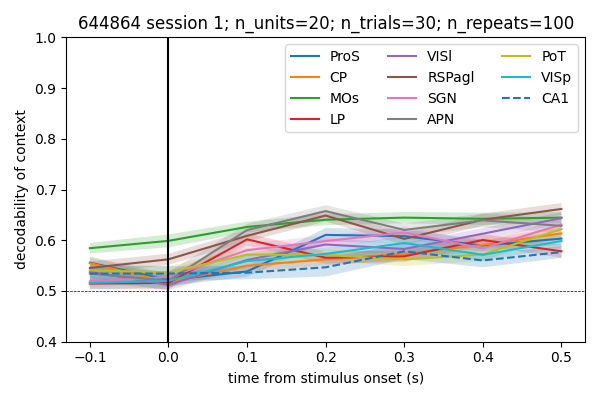

probeA areas found
probeC areas found
probeD areas found
probeE areas found
probeF areas found


C:\Users\ethan.mcbride\Code\dynamic_routing_ephys\analysis\DR_analysis_utils.py:1069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stimTrials[ss+'_smooth']=sg.convolve(stimTrials['trial_response'].values,gwindow,mode='same')/np.sum(gwindow)
C:\Users\ethan.mcbride\Code\dynamic_routing_ephys\analysis\DR_analysis_utils.py:1069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stimTrials[ss+'_smooth']=sg.convolve(stimTrials['trial_response'].values,gwindow,mode='same')/np.sum(gwindow)
C:\Users\ethan.mcbride\Code\

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

ProS done


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

LP done


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

VISl done


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

MOs done


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

CP done


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

DG done


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

RSPd done


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

PoT done


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

SGN done


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

CA1 done


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

MRN done


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

VISp done


<IPython.core.display.Javascript object>


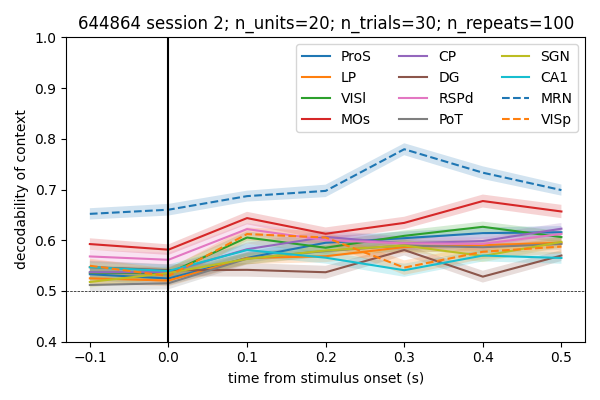

probeA areas found
probeB areas found
probeC areas found
probeD areas not found
probeE areas found
probeF areas found


C:\Users\ethan.mcbride\Code\dynamic_routing_ephys\analysis\DR_analysis_utils.py:1069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stimTrials[ss+'_smooth']=sg.convolve(stimTrials['trial_response'].values,gwindow,mode='same')/np.sum(gwindow)
C:\Users\ethan.mcbride\Code\dynamic_routing_ephys\analysis\DR_analysis_utils.py:1069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stimTrials[ss+'_smooth']=sg.convolve(stimTrials['trial_response'].values,gwindow,mode='same')/np.sum(gwindow)
C:\Users\ethan.mcbride\Code\

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

MOs done


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

CP done


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

VISpm done


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

VISrl done


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

RSPv done


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

VISl done


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

SUB done


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

POL done


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

CA1 done


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

RSPd done


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

LP done


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

SGN done


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

MD done


<IPython.core.display.Javascript object>


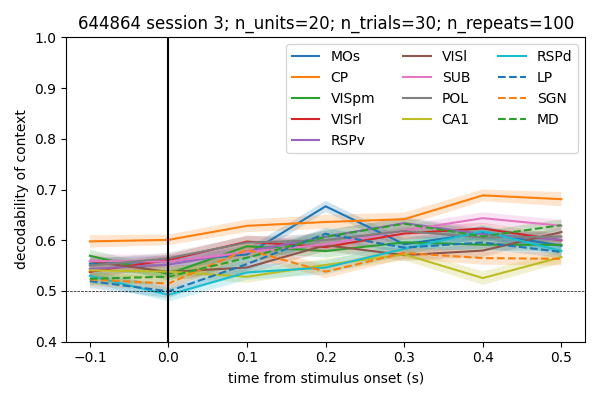

probeA areas found
probeB areas found
probeC areas found
probeD areas not found
probeE areas found
probeF areas found


C:\Users\ethan.mcbride\Code\dynamic_routing_ephys\analysis\DR_analysis_utils.py:1069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stimTrials[ss+'_smooth']=sg.convolve(stimTrials['trial_response'].values,gwindow,mode='same')/np.sum(gwindow)
C:\Users\ethan.mcbride\Code\dynamic_routing_ephys\analysis\DR_analysis_utils.py:1069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stimTrials[ss+'_smooth']=sg.convolve(stimTrials['trial_response'].values,gwindow,mode='same')/np.sum(gwindow)
C:\Users\ethan.mcbride\Code\

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

LP done


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

RSPagl done


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

ProS done


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

VISrl done


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

VISl done


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

CA1 done


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

LGd done


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

PoT done


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarni

VISam done


<IPython.core.display.Javascript object>


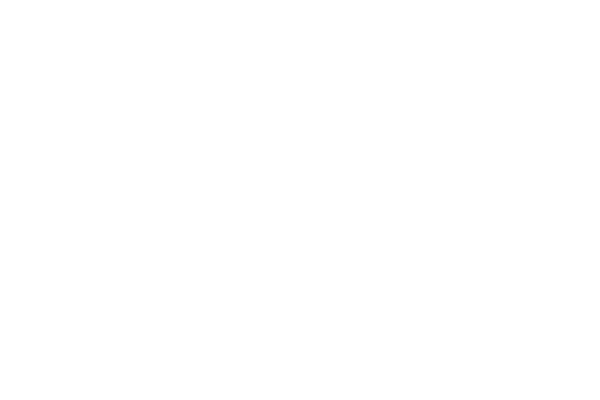

In [5]:
trnum=30
u_num=20
n_repeats=100
binsize=0.1
time_bins=np.arange(-0.2,0.6,binsize)

for sel_session, path in enumerate(main_path):
    
    session=[]
    session=Session(path=path) 
    session.assign_unit_areas()
    session=compute_smoothed_response_rate(session)
    
    # loop through sessions and make unit xarrays
    time_before_flash = 0.25
    trial_duration = 1.0
    bin_size = 0.001

    # Make tensor (3-D matrix [units,time,trials])
    trial_tensor = make_neuron_time_trials_tensor(session.good_units, session.spike_times, 
                                                  session.trials,time_before_flash, trial_duration, 
                                                  bin_size)
    # make xarray
    session.trial_da = xr.DataArray(trial_tensor, dims=("unit_id", "time", "trials"), 
                               coords={
                                   "unit_id": session.good_units.index.values,
                                   "time": np.arange(0, trial_duration, bin_size)-time_before_flash,
                                   "trials": session.trials.index.values
                                   })
    
    #shorten the area names to better lump together units
    #get rig of layers and/or sub-areas with dashes
    area_short = []
    for area in session.good_units['area']:
        if area=='N/A':
            short='N/A'
        elif area[:2]=='CA':
            short=area
        else:
            dig_ind=re.search(r"\d", area)
            dash_ind=re.search(r"-", area)
            if dig_ind!=None:
                short=area[:dig_ind.start()]
            elif dash_ind!=None:
                short=area[:dash_ind.start()]
            else:
                short=area
        area_short.append(short)
    session.good_units['area_short']=area_short
    area_counts=session.good_units['area_short'].value_counts()
    
    #try more timepoints & split by areas
    svc_results={}
    

    # grab data: make these [trials,neurons] matrices based on different time bins:

    hit_trials = session.trials.query(
        '(trialStimID == "vis1" and \
        trialstimRewarded == "vis1" and \
        trial_response == True and \
        vis_autoreward_trials == False) or \
        (trialStimID == "sound1" and \
        trialstimRewarded == "sound1" and \
        trial_response == True and \
        vis_autoreward_trials == False)').index

    cr_trials = session.trials.query(
        '(trialStimID == "vis1" and \
        trialstimRewarded == "sound1" and \
        trial_response == False and \
        vis_autoreward_trials == False) or \
        (trialStimID == "sound1" and \
        trialstimRewarded == "vis1" and \
        trial_response == False and \
        vis_autoreward_trials == False)').index


    trial_sel=np.sort(np.hstack([hit_trials,cr_trials]))

    

    # grab the stimulus ids
    stim_ids = session.trials['trialStimID'][trial_sel].values
    # or, use block IDs
    block_ids = session.trials['trialstimRewarded'][trial_sel].values
    #or, use whether mouse responded
    trial_response = session.trials['trial_response'][trial_sel].values

    #choose what variable to predict
    pred_var = block_ids

#     ### make sure equal # of trials per condition!
#     conds = np.unique(pred_var)
#     cond_count = np.zeros(len(conds))
#     for ic,cc in enumerate(conds):
#         cond_count[ic]=np.sum(pred_var==cc)
#     min_n_trials=np.min(cond_count).astype(int)
#     subset_ind=[]
#     for cc in conds:
#         cond_inds=np.where(pred_var==cc)[0]
#         subset_ind.append(np.random.choice(cond_inds,min_n_trials,replace=False))   
#     subset_ind=np.sort(np.hstack(subset_ind))
#     trial_sel=trial_sel[subset_ind]
#     pred_var=pred_var[subset_ind]


    area_sel = area_counts[area_counts>=u_num].index
    # area_sel = ['all']

    for aa in area_sel:
        if aa=='all':
            unit_sel = session.good_units.index.values
        else:
            unit_sel = session.good_units.query('area_short==@aa').index.values
        svc_results[aa]={}

        for tt,t_start in enumerate(time_bins[:-1]):
            svc_results[aa][tt]={}

            for nn in range(0,n_repeats):
                unit_subset = np.random.choice(unit_sel,u_num,replace=True)

                ### make sure equal # of trials per condition!
                subset_ind=[]
                conds = np.unique(pred_var)
                cond_count=[]

                for cc in conds:
                    cond_inds=np.where(pred_var==cc)[0]
                    if len(cond_inds)<trnum:
                        trnum=len(cond_inds)
                    subset_ind.append(np.random.choice(cond_inds,trnum,replace=False))   
                subset_ind=np.sort(np.hstack(subset_ind))

                sel_data = session.trial_da.sel(time=slice(t_start,time_bins[tt+1]),
                                                trials=trial_sel[subset_ind],
                                                unit_id=unit_subset).mean(dim='time').values

                X = sel_data.T
                y = pred_var[subset_ind].flatten()

                xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.5, stratify=y)

                clf = svm.LinearSVC()
                clf.fit(xtrain, ytrain)

                ypred = clf.predict(xtest)

                cr_dict=classification_report(ytest, ypred, output_dict=True)
                cr_df=pd.DataFrame.from_dict(cr_dict)

                svc_results[aa][tt][nn]=cr_df

        print(aa+' done')
        
        
    # make into more plottable format
    plot_results={}
    timepoints=time_bins[1:]
    areas=area_sel

    for aa in areas:
        plot_results[aa]={}
        plot_results[aa]['vis1']=np.zeros((len(timepoints),n_repeats))
        plot_results[aa]['vis1'][:]=np.nan
        plot_results[aa]['aud1']=np.zeros((len(timepoints),n_repeats))
        plot_results[aa]['aud1'][:]=np.nan
        
        plot_results[aa]['True']=np.zeros((len(timepoints),n_repeats))
        plot_results[aa]['True'][:]=np.nan
        plot_results[aa]['False']=np.zeros((len(timepoints),n_repeats))
        plot_results[aa]['False'][:]=np.nan

    # diff table for each timepoint?
    # row = session
    # columns = ['modality','A_vis','A_aud','B_vis','B_aud','C_vis','C_aud','F_vis','F_aud',]

    for aa in areas: #svc_results[ss]['results'].keys():
        if aa in svc_results.keys():
            for tt,tp in enumerate(timepoints):

                for nn in range(0,n_repeats):
                    if 'vis1' in svc_results[aa][tt][nn].keys():
                        vis1_perf=np.mean(svc_results[aa][tt][nn]['vis1'][['precision','recall']].values)
                        plot_results[aa]['vis1'][tt,nn]=vis1_perf

                    if 'sound1' in svc_results[aa][tt][nn].keys():
                        aud1_perf=np.mean(svc_results[aa][tt][nn]['sound1'][['precision','recall']].values)
                        plot_results[aa]['aud1'][tt,nn]=aud1_perf
                        
                    if 'True' in svc_results[aa][tt][nn].keys():
                        vis1_perf=np.mean(svc_results[aa][tt][nn]['True'][['precision','recall']].values)
                        plot_results[aa]['True'][tt,nn]=vis1_perf

                    if 'False' in svc_results[aa][tt][nn].keys():
                        aud1_perf=np.mean(svc_results[aa][tt][nn]['False'][['precision','recall']].values)
                        plot_results[aa]['False'][tt,nn]=aud1_perf
    
    
    
    fig,ax=plt.subplots(1,1,figsize=(6,4))

    for aa,area in enumerate(plot_results.keys()):
        y=np.nanmean([np.mean(plot_results[area]['vis1'],1),np.mean(plot_results[area]['aud1'],1)],0)
        yerr=np.std(np.hstack([plot_results[area]['vis1'],plot_results[area]['aud1']]),1)/np.sqrt(n_repeats)
        
#         y=np.nanmean([np.mean(plot_results[area]['True'],1),np.mean(plot_results[area]['False'],1)],0)
#         yerr=np.std(np.hstack([plot_results[area]['True'],plot_results[area]['False']]),1)/np.sqrt(n_repeats)
        
        if aa>19:
            linex=ax.plot(timepoints,y,linestyle='-.')
        elif aa>9:
            linex=ax.plot(timepoints,y,linestyle='--')
        else:
            linex=ax.plot(timepoints,y)
        plt.fill_between(timepoints, y-yerr, y+yerr,
                        alpha=0.2, edgecolor=None, facecolor=linex[0].get_color())

    ax.set_ylim([0.4,1.0])
    ax.axvline(0,color='k')
    ax.axhline(0.5,color='k',linewidth=0.5,linestyle='--')
    ax.set_title(session.metadata['mouseID']+' session '+str(session.metadata['ephys_session_num'])+
                '; n_units='+str(u_num)+'; n_trials='+str(trnum)+'; n_repeats='+str(n_repeats))
    ax.legend(plot_results.keys(),ncol=3)
    ax.set_ylabel('decodability of context')
    ax.set_xlabel('time from stimulus onset (s)')
    fig.tight_layout()
    
    figpath=r"C:\Users\ethan.mcbride\OneDrive - Allen Institute\quick figures\2023-03-30-DR_SAC_decoding_context"

    figname=(session.metadata['mouseID']+'_session_'+str(session.metadata['ephys_session_num'])+
                '_n_units_'+str(u_num)+'_n_trials_'+str(trnum)+'_n_repeats_'+str(n_repeats)+'.png')
    # figname='control_heatmap_500ms_all.png'
    plt.savefig(os.path.join(figpath,figname), dpi=600, facecolor='w', edgecolor='w',
                orientation='portrait', format='png',
                transparent=True, bbox_inches='tight', pad_inches=0.1,
                metadata=None)
    


In [ ]:
cond_inds.shape

In [ ]:
unit_sel

In [ ]:
session.good_units.query('area_short==@aa').index.values

In [ ]:
session.good_units['area_short'].unique()

## loop through experiments & save

In [ ]:
trnum='all'
u_num=20
n_repeats=100
binsize=0.1
time_bins=np.arange(-0.2,0.6,binsize)
        
svc_results={}

for sel_session, path in enumerate(main_path):
    
    svc_results[sel_session]={}
    
    session=[]
    session=Session(path=path) 
    session.assign_unit_areas()
    session=compute_smoothed_response_rate(session)
    
    # loop through sessions and make unit xarrays
    time_before_flash = 0.25
    trial_duration = 1.0
    bin_size = 0.001

    # Make tensor (3-D matrix [units,time,trials])
    trial_tensor = make_neuron_time_trials_tensor(session.good_units, session.spike_times, 
                                                  session.trials,time_before_flash, trial_duration, 
                                                  bin_size)
    # make xarray
    session.trial_da = xr.DataArray(trial_tensor, dims=("unit_id", "time", "trials"), 
                               coords={
                                   "unit_id": session.good_units.index.values,
                                   "time": np.arange(0, trial_duration, bin_size)-time_before_flash,
                                   "trials": session.trials.index.values
                                   })
    
    #shorten the area names to better lump together units
    #get rig of layers and/or sub-areas with dashes
    area_short = []
    for area in session.good_units['area']:
        if area=='N/A':
            short='N/A'
        elif area[:2]=='CA':
            short=area
        else:
            dig_ind=re.search(r"\d", area)
            dash_ind=re.search(r"-", area)
            if dig_ind!=None:
                short=area[:dig_ind.start()]
            elif dash_ind!=None:
                short=area[:dash_ind.start()]
            else:
                short=area
        area_short.append(short)
    session.good_units['area_short']=area_short
    area_counts=session.good_units['area_short'].value_counts()

    # grab data: make these [trials,neurons] matrices based on different time bins:

    hit_trials = session.trials.query(
        '(trialStimID == "vis1" and \
        trialstimRewarded == "vis1" and \
        trial_response == True and \
        vis_autoreward_trials == False) or \
        (trialStimID == "sound1" and \
        trialstimRewarded == "sound1" and \
        trial_response == True and \
        vis_autoreward_trials == False)').index

    cr_trials = session.trials.query(
        '(trialStimID == "vis1" and \
        trialstimRewarded == "sound1" and \
        trial_response == False and \
        vis_autoreward_trials == False) or \
        (trialStimID == "sound1" and \
        trialstimRewarded == "vis1" and \
        trial_response == False and \
        vis_autoreward_trials == False)').index

    
    
    trial_sel=np.sort(np.hstack([hit_trials,cr_trials]))
    
    predict=['stim_ids','block_ids','trial_response']

    # grab the stimulus ids
    stim_ids = session.trials['trialStimID'][trial_sel].values
    # or, use block IDs
    block_ids = session.trials['trialstimRewarded'][trial_sel].values
    #or, use whether mouse responded
    trial_response = session.trials['trial_response'][trial_sel].values
      
    for p in predict:
        svc_results[sel_session][p]={}
    
        #choose what variable to predict
        if p=='stim_ids':
            pred_var = stim_ids
        elif p=='block_ids':
            pred_var = block_ids
        elif p=='trial_response':
            pred_var = trial_response

        area_sel = area_counts[area_counts>=u_num].index
        # area_sel = ['all']

        for aa in area_sel:
            if aa=='all':
                unit_sel = session.good_units.index.values
            else:
                unit_sel = session.good_units.query('area_short==@aa').index.values
            svc_results[sel_session][p][aa]={}

            for tt,t_start in enumerate(time_bins[:-1]):
                svc_results[sel_session][p][aa][tt]={}

                for nn in range(0,n_repeats):
                    unit_subset = np.random.choice(unit_sel,u_num,replace=True)

                    ### make sure equal # of trials per condition!
                    subset_ind=[]
                    conds = np.unique(pred_var)
                    cond_count=[]
                    
                    if trnum=='all':
                        for cc in conds:
                            cond_count.append(np.sum(pred_var==cc))
                        trnum=np.min(cond_count)
                    
                    for cc in conds:
                        cond_inds=np.where(pred_var==cc)[0]
                        if len(cond_inds)<trnum:
                            trnum=len(cond_inds)
                        subset_ind.append(np.random.choice(cond_inds,trnum,replace=False))   
                    subset_ind=np.sort(np.hstack(subset_ind))

                    sel_data = session.trial_da.sel(time=slice(t_start,time_bins[tt+1]),
                                                    trials=trial_sel[subset_ind],
                                                    unit_id=unit_subset).mean(dim='time').values

                    X = sel_data.T
                    y = pred_var[subset_ind].flatten()

                    xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.5, stratify=y)

                    clf = svm.LinearSVC()
                    clf.fit(xtrain, ytrain)

                    ypred = clf.predict(xtest)

                    cr_dict=classification_report(ytest, ypred, output_dict=True)
                    cr_df=pd.DataFrame.from_dict(cr_dict)

                    svc_results[sel_session][p][aa][tt][nn]=cr_df

            print(aa+' done')

            
savepath=r'C:\Users\ethan.mcbride\OneDrive - Allen Institute\DR decoding results'

with open(os.path.join(savepath,'decoder_results_100ms.pkl'), 'wb') as handle:
    pickle.dump(svc_results, handle, protocol=pickle.HIGHEST_PROTOCOL)        

probeA areas found
probeB areas found
probeC areas found
probeD areas not found
probeE areas found
probeF areas found


C:\Users\ethan.mcbride\Code\dynamic_routing_ephys\analysis\DR_analysis_utils.py:1069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stimTrials[ss+'_smooth']=sg.convolve(stimTrials['trial_response'].values,gwindow,mode='same')/np.sum(gwindow)
C:\Users\ethan.mcbride\Code\dynamic_routing_ephys\analysis\DR_analysis_utils.py:1069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stimTrials[ss+'_smooth']=sg.convolve(stimTrials['trial_response'].values,gwindow,mode='same')/np.sum(gwindow)
C:\Users\ethan.mcbride\Code\